In [4]:
import sys

sys.path.append('../')

from scipy.io import loadmat
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
#import pyinform as pyinform
#import pwlf
import time
from IPython.display import display, clear_output

import ieeg_utilities as ieeg

ModuleNotFoundError: No module named 'code.ieeg_utilities'; 'code' is not a package

In [4]:
sample_size = 60 # s

# Load data
data_mat = loadmat('../data/ID11_60h.mat')
info_mat = loadmat('../data/ID11_info.mat')
sampling_frequency = info_mat['fs']
sample_begin = int(5*60*sampling_frequency)
sample_end = sample_begin + int(sample_size*sampling_frequency)
data_raw = data_mat['EEG'][:, sample_begin:sample_end].transpose()
#data_raw = data_raw[:10000, :]
print(sampling_frequency)
print("all data", data_mat['EEG'].shape)
print("data sample", data_raw.shape)

[[1024]]
(32, 3686400)


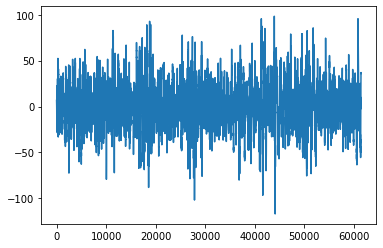

In [52]:
plt.plot(data_raw[:, 0])

In [53]:
# for i in range(data_raw.shape[1]):
#     #plt.figure()
#     plt.hist(data_raw[: i], bins=30, alpha=0.3,
#              histtype='stepfilled',
#              edgecolor='none')
#
# plt.savefig(f"all.svg")

/home/benelot/miniconda3/envs/eeg-learning/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


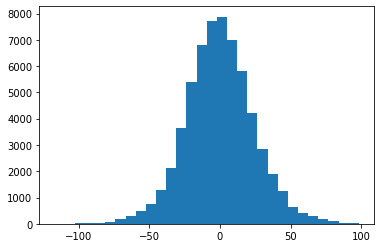

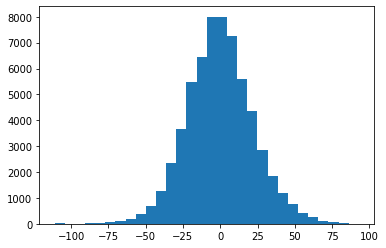

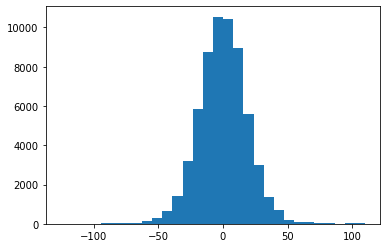

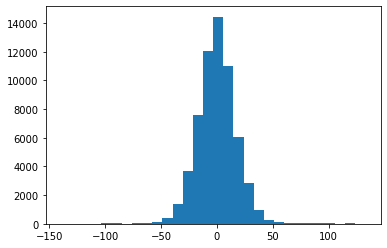

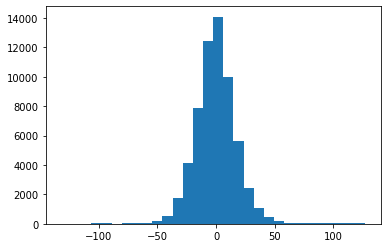

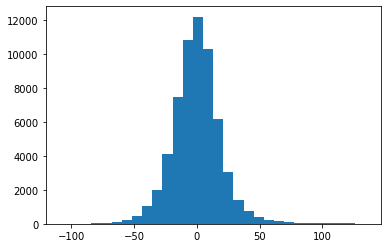

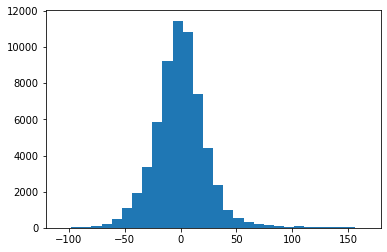

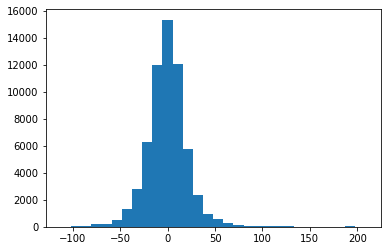

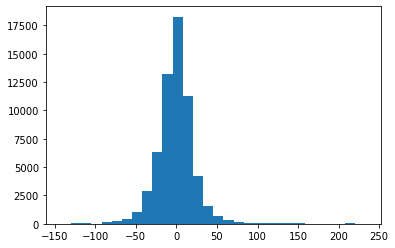

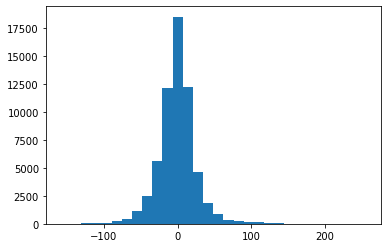

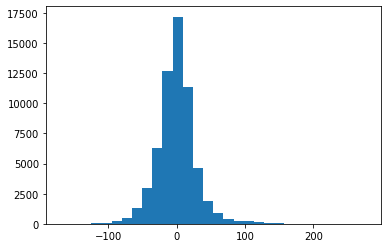

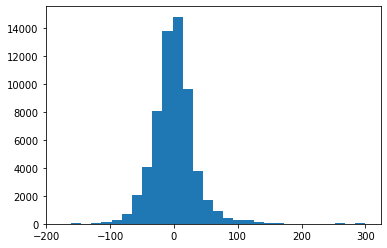

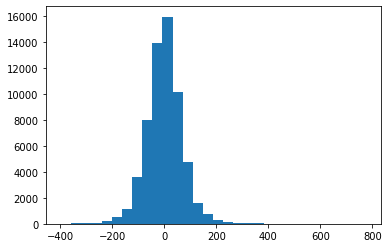

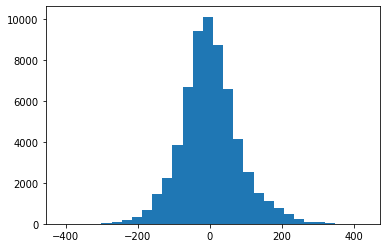

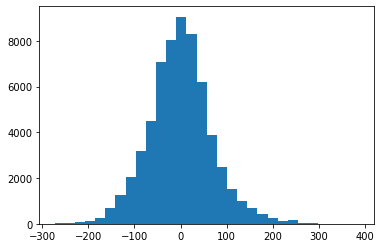

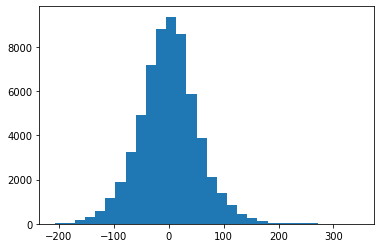

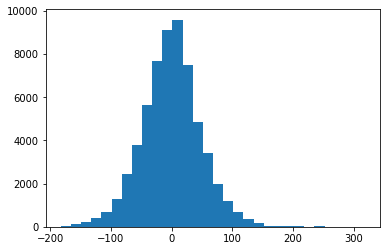

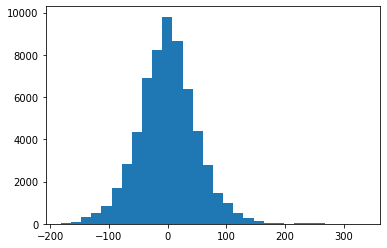

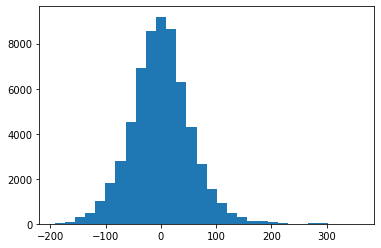

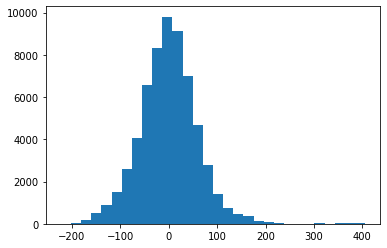

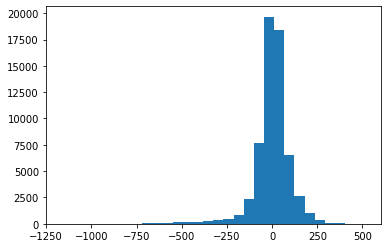

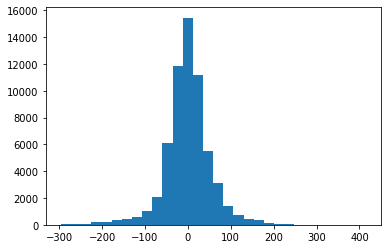

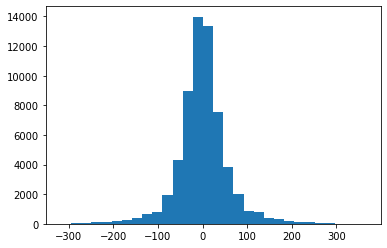

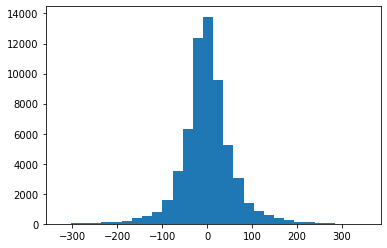

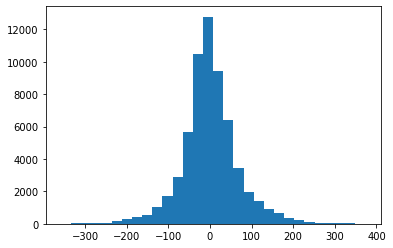

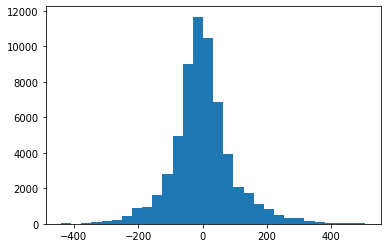

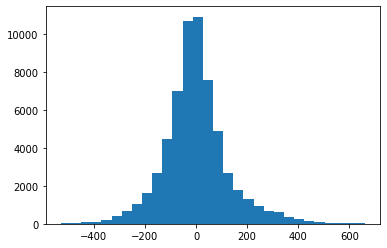

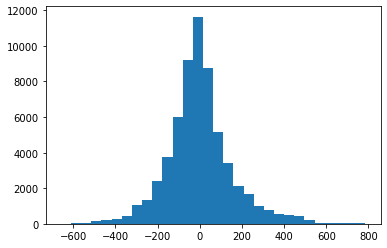

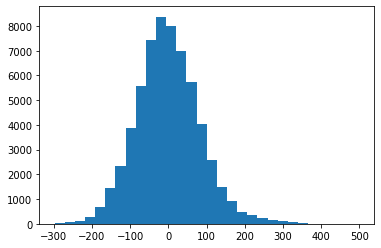

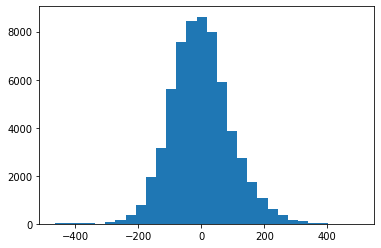

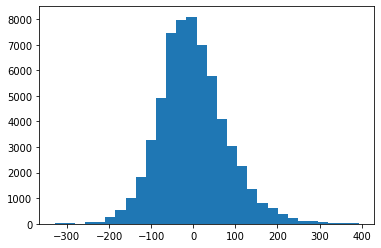

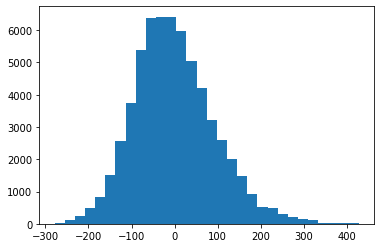

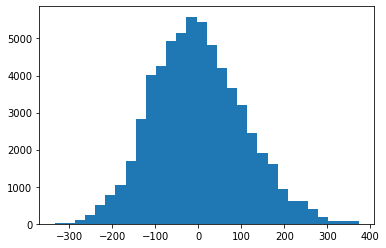

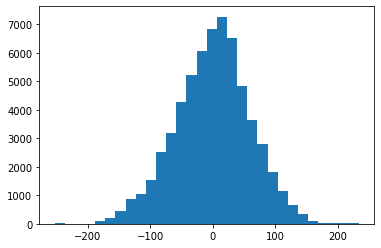

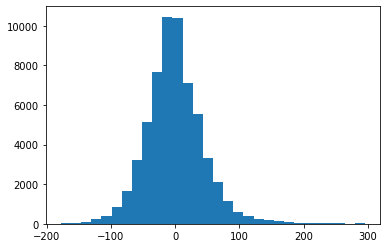

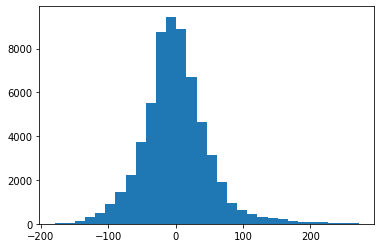

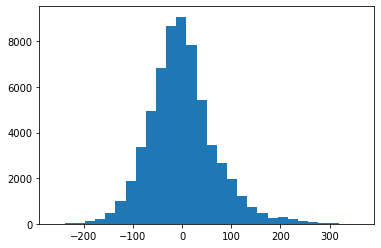

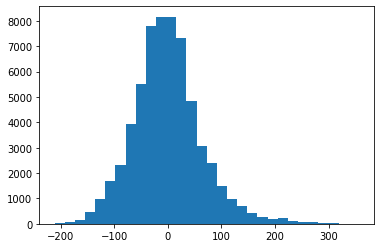

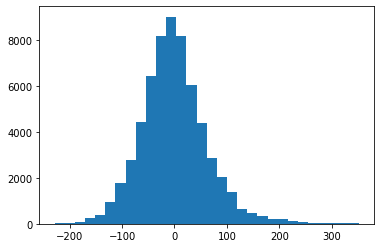

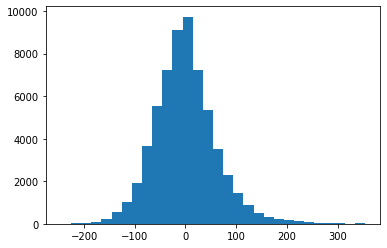

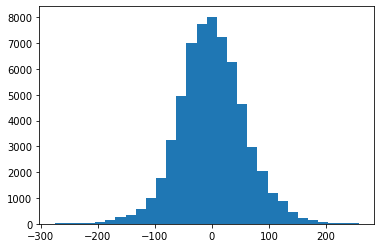

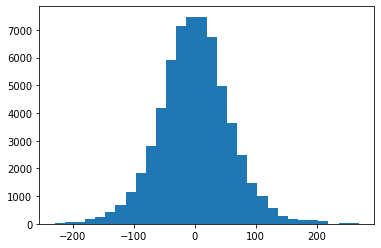

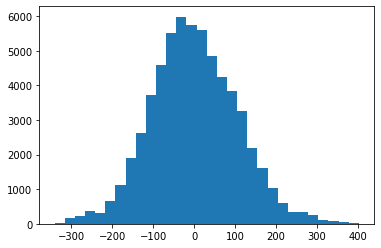

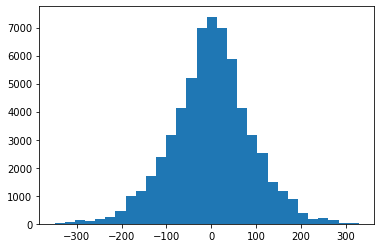

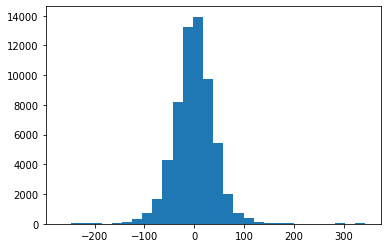

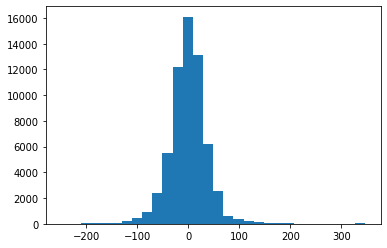

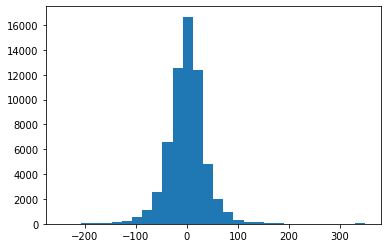

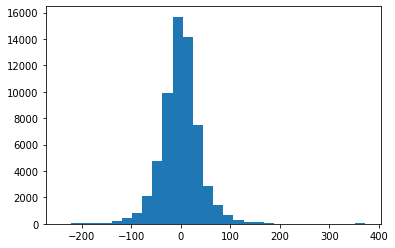

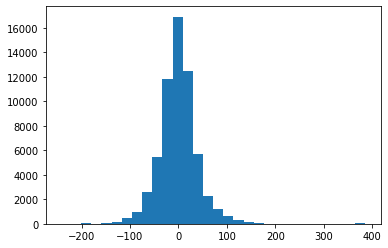

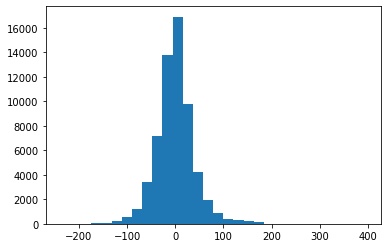

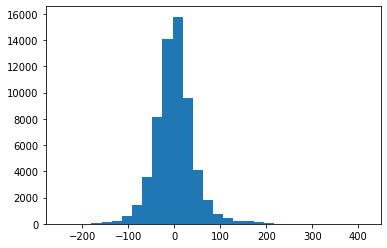

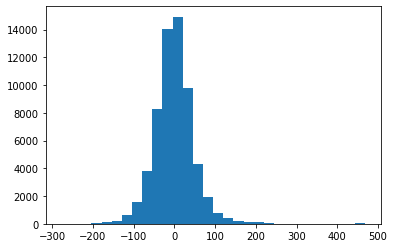

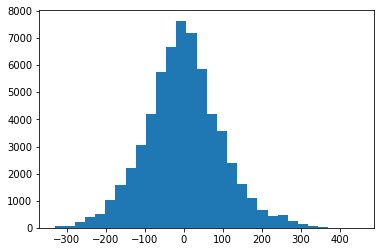

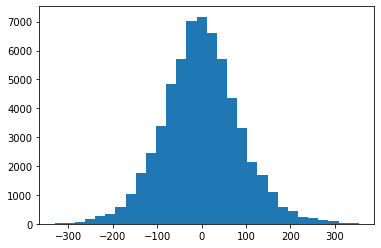

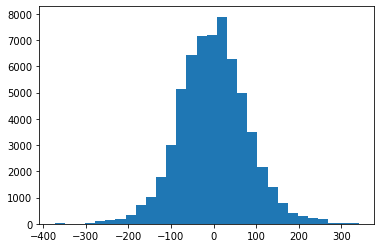

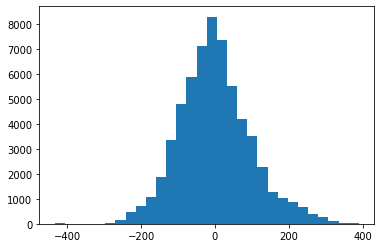

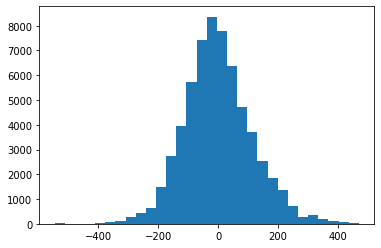

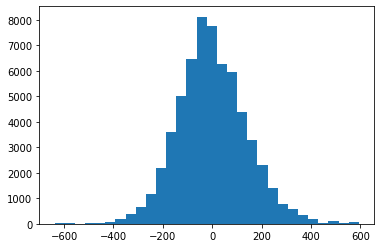

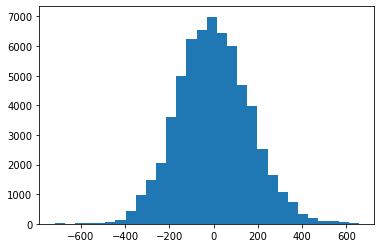

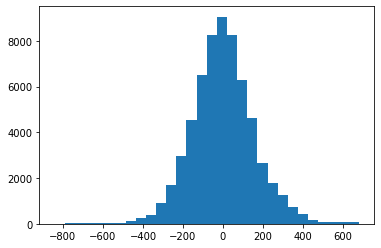

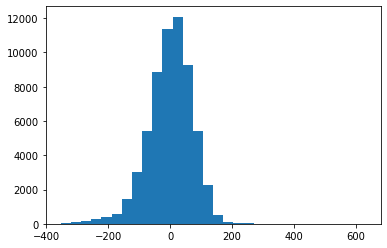

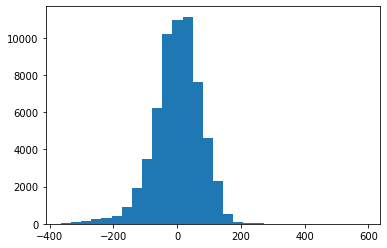

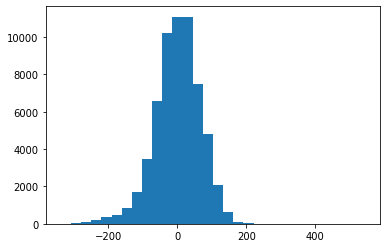

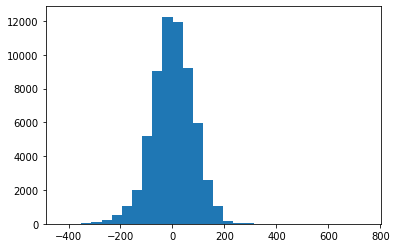

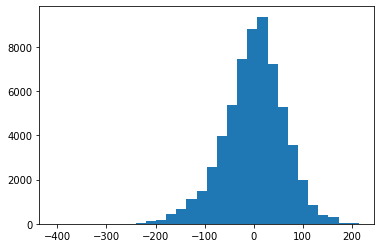

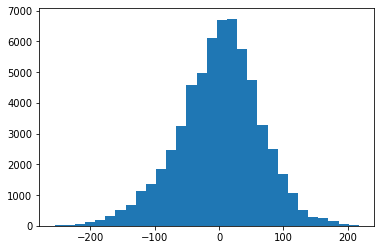

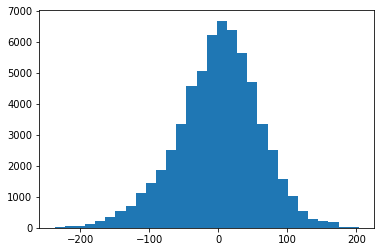

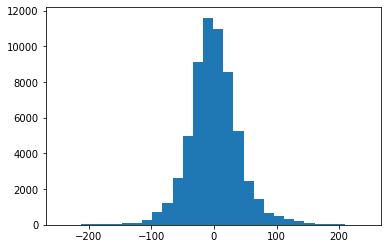

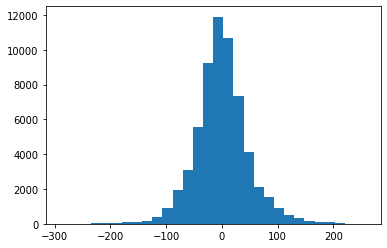

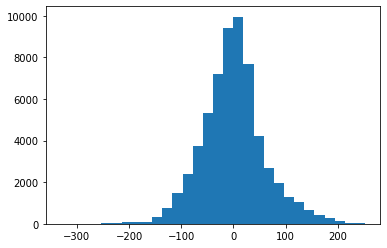

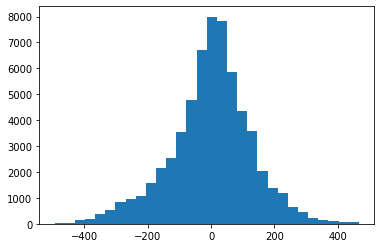

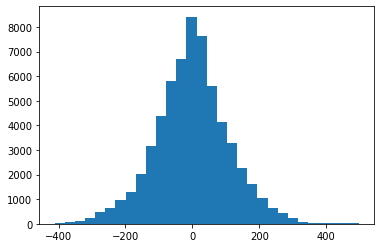

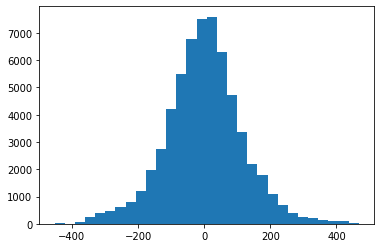

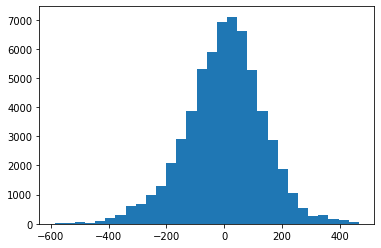

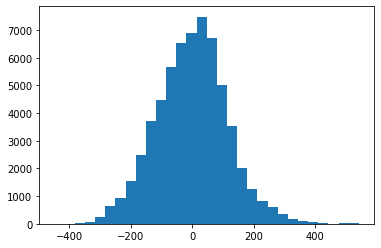

In [55]:
for i in range(data_raw.shape[1]):
    plt.figure()
    plt.hist(data_raw[:, i], bins=30, alpha=1.0,
             histtype='stepfilled',
             edgecolor='none')

    plt.savefig(f"{i}.svg")

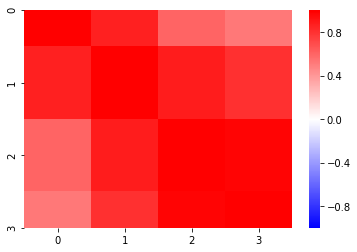

In [24]:
simple_r = np.corrcoef(data_raw.T)
sns.heatmap(simple_r, cmap='bwr', vmin=-1, vmax=1)

In [5]:
t_shift = int(0.1*fs)  # samples
h2 = np.zeros((data_raw.shape[1], data_raw.shape[1]))
r = np.zeros((data_raw.shape[1], data_raw.shape[1]))
h2_x_to_y = np.zeros((data_raw.shape[1], data_raw.shape[1]))
r_x_to_y = np.zeros((data_raw.shape[1], data_raw.shape[1]))
h2_shift_list = []
r_shift_list = []

start_time = time.time()

for i in range(data_raw.shape[1]):
    for j in range(data_raw.shape[1]):
        h2[i, j], r[i, j], h2_x_to_y[i, j], r_x_to_y[i, j], h2_shift, r_shift = ieeg.correlation_metrics(data_raw[:, i], data_raw[:, j], t_shift=t_shift)
        h2_shift_list.append(h2_shift)
        r_shift_list.append(r_shift)
    t_rem = (time.time() - start_time)/(i+1)*(data_raw.shape[1]-i+1)
    clear_output()
    print(f'Computed columns: {i}/{data_raw.shape[1]} | Time remaining [min]: {t_rem/60:.3}')

KeyboardInterrupt: 

In [20]:
np.save('../data/FC_ID11_60h5m_h2.npy', h2)
np.save('../data/FC_ID11_60h5m_h2shift.npy', h2_x_to_y)
np.save('../data/FC_ID11_60h5m_r2.npy', r)
np.save('../data/FC_ID11_60h5m_r2shift.npy', r_x_to_y)

73.2234034538269

In [3]:
# Normalizing
ssc = StandardScaler()
data_ssc = ssc.fit_transform(data_raw)

mmsc = MinMaxScaler(feature_range=(0, 1))
data_mmsc = mmsc.fit_transform(data_raw)

data_global_ssc = (data_raw - np.mean(data_raw))/np.std(data_raw)

X = data_raw
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
data_global_mmsc = X_std * (np.max(X) - np.min(X)) + np.min(X)

<Figure size 1080x1080 with 0 Axes>

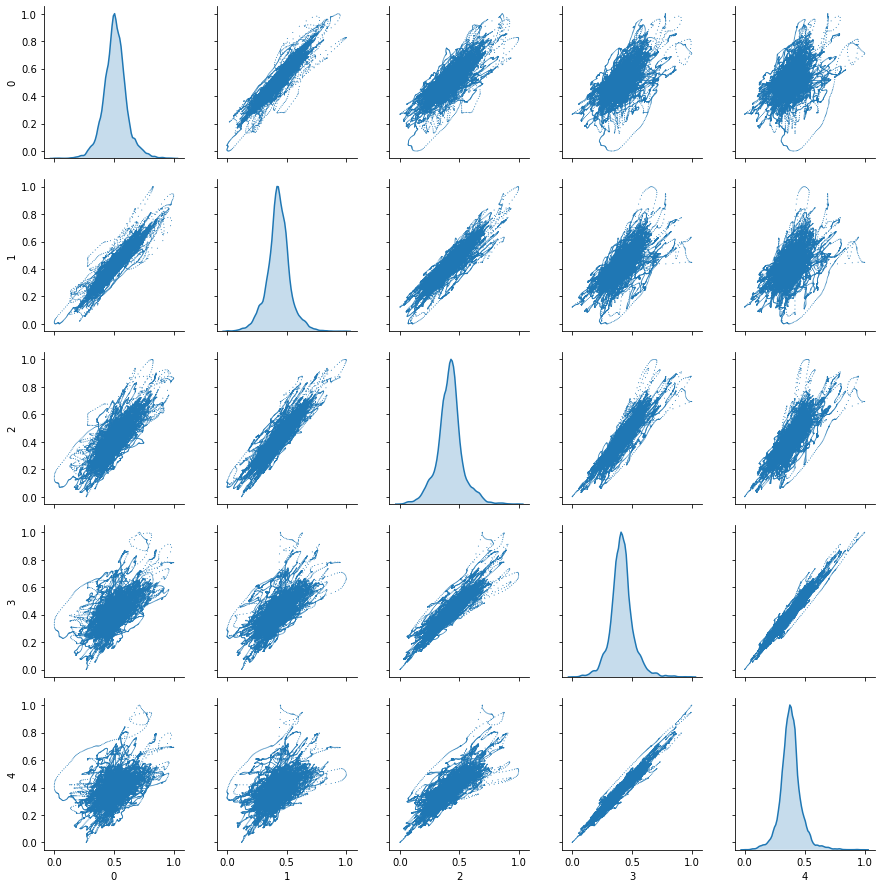

In [10]:
data_mmsc[:,3] = 1/(1 + np.exp(-data_mmsc[:,3]*8)) 
df = pd.DataFrame(data_mmsc[:, :5])
plt.figure(figsize=(15,15))
sns.pairplot(df, diag_kind='kde', plot_kws={'color': 'tab:blue', 's': 1, 'edgecolor': 'none', 'alpha': 1})
#plt.savefig('distribution.png')

In [2]:
h2 = np.load('../data/FC_ID11_60h5m_h2.npy')
h2shift = np.load('../data/FC_ID11_60h5m_h2shift.npy')
r2 = np.load('../data/FC_ID11_60h5m_r2.npy')
r2shift = np.load('../data/FC_ID11_60h5m_r2shift.npy')



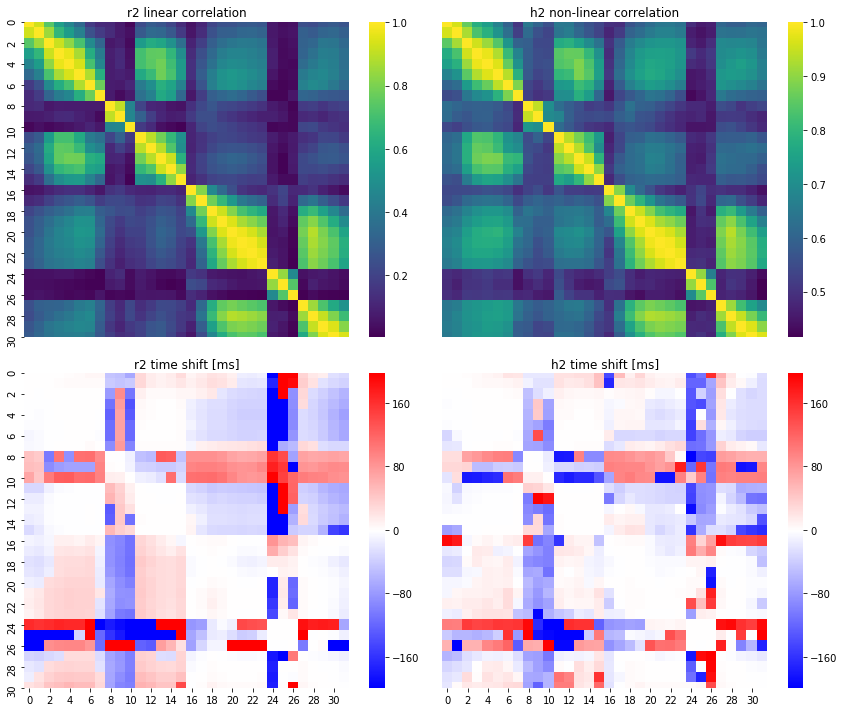

In [5]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2)
cmap = 'viridis'

ax0 = fig.add_subplot(gs[:1, :1])
sns.heatmap(r2, cmap=cmap)
ax0.set_title('r2 linear correlation')
ax0.get_xaxis().set_visible(False)

ax1 = fig.add_subplot(gs[:1, 1:])
sns.heatmap(h2, cmap=cmap)
ax1.set_title('h2 non-linear correlation')
ax1.get_xaxis().set_visible(False), ax1.get_yaxis().set_visible(False)

ax2 = fig.add_subplot(gs[1:, :1])
sns.heatmap(r2shift/fs*1000, cmap='bwr')
ax2.set_title('r2 time shift [ms]')

ax3 = fig.add_subplot(gs[1:, 1:])
sns.heatmap(h2shift/fs*1000, cmap='bwr')
ax3.set_title('h2 time shift [ms]')
ax3.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig('FC_ID11_60h05m.png')
plt.show()

In [53]:
print(np.mean(np.corrcoef(data_raw.T)))
print(np.mean(r2))

0.06591850697421636
0.3453278043491703


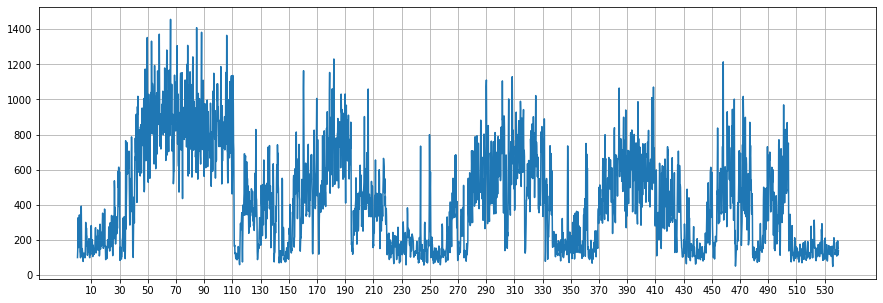

In [7]:
swa = np.mean(Sxx_band_tukey, axis=0)
plt.figure(figsize=(15, 5))
plt.xticks(np.arange(t[0], t[-1]/60, 20))
#plt.ylim(0,250)
#plt.xlim(170, 190)
plt.plot(t/60, swa)
plt.grid()
plt.savefig('ID08N3.png')


In [15]:
fs

1024.0

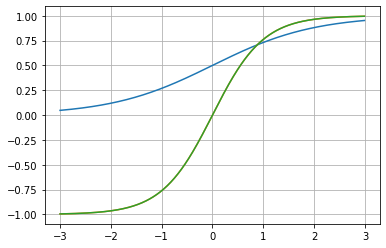

In [8]:
x = np.arange(-3, 3, 0.01)
sig = 1/(1 + np.exp(-x))
sig_4 = 2 * (1/(1 + np.exp(-2*(x-0.0)))) -1
tanh = np.tanh(x)
plt.plot(x, sig)
plt.plot(x, sig_4)
plt.plot(x, tanh)
plt.grid()

<function max>